![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest parameter optimization
</b>
</span>

---
**Notebook version**: `1` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch) 

</br>

# **Background**

- Finding optimal model parameters

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [2]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [3]:
import importlib.metadata
from datetime import datetime
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.gapfilling.randomforest_ts import OptimizeParamsRFTS
import matplotlib.pyplot as plt
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

diive version: v0.63.1


</br>

# **Docstring** for `RandomForestTS`

In [4]:
help(OptimizeParamsRFTS)

Help on class OptimizeParamsRFTS in module diive.pkgs.gapfilling.randomforest_ts:

class OptimizeParamsRFTS(builtins.object)
 |  OptimizeParamsRFTS(df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |  
 |  Optimize parameters for random forest model
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |      Args:
 |          df: dataframe of target and predictor time series
 |          target_col: name of target in *df*, all variables that are not *target* are
 |              used as predictors
 |          **rf_params: dict of parameters for random forest model, where parameter ranges are
 |              provided as lists, e.g.
 |                  rf_params = {
 |                      'n_estimators': list(range(2, 12, 2)),
 |                      'criterion': ['squared_error'],
 |                      'max_depth': [None],
 |                      'min_samples_split': list(range(2, 12, 2)),
 |   

</br>

# **Load data**

## Load example data from parquet file

In [5]:
df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.071 seconds). Detected time resolution of <30 * Minutes> / 30T 


## Make subset

In [6]:
subset = df[subsetcols].copy()
_subset = df.index.year == 2019
subset = subset[_subset].copy()
subset

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
TIMESTAMP_MIDDLE,,,,
2019-01-01 00:15:00,NaN,-3.380,0.274,0.0
2019-01-01 00:45:00,NaN,-3.357,0.331,0.0
2019-01-01 01:15:00,NaN,-3.607,0.258,0.0
2019-01-01 01:45:00,-3.144272,-3.890,0.244,0.0
2019-01-01 02:15:00,NaN,-4.003,0.339,0.0
...,...,...,...,...
2019-12-31 21:45:00,NaN,-2.440,1.587,0.0
2019-12-31 22:15:00,NaN,-2.447,1.591,0.0
2019-12-31 22:45:00,NaN,-2.455,1.594,0.0


In [7]:
subset.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,6352.000000,17520.000000,17520.000000,17520.000000
mean,-3.227766,4.783583,3.357885,150.497459
std,6.368514,7.797762,4.127673,246.515514
min,-37.556730,-15.450000,0.000000,0.000000
25%,-7.362526,-1.097000,0.661000,0.000000
50%,-2.593985,4.343000,1.912500,2.494000
75%,1.046685,10.377000,4.415000,213.924500
max,23.234300,28.713000,32.118000,1144.630000


In [8]:
sstats(subset[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2019-01-01 00:15
ENDDATE,2019-12-31 23:45
PERIOD,364 days 23:30:00
NOV,6352
MISSING,11168
MISSING_PERC,63.744292
MEAN,-3.227766
SD,6.368514
VAR,40.557966
SD/MEAN,-1.97304


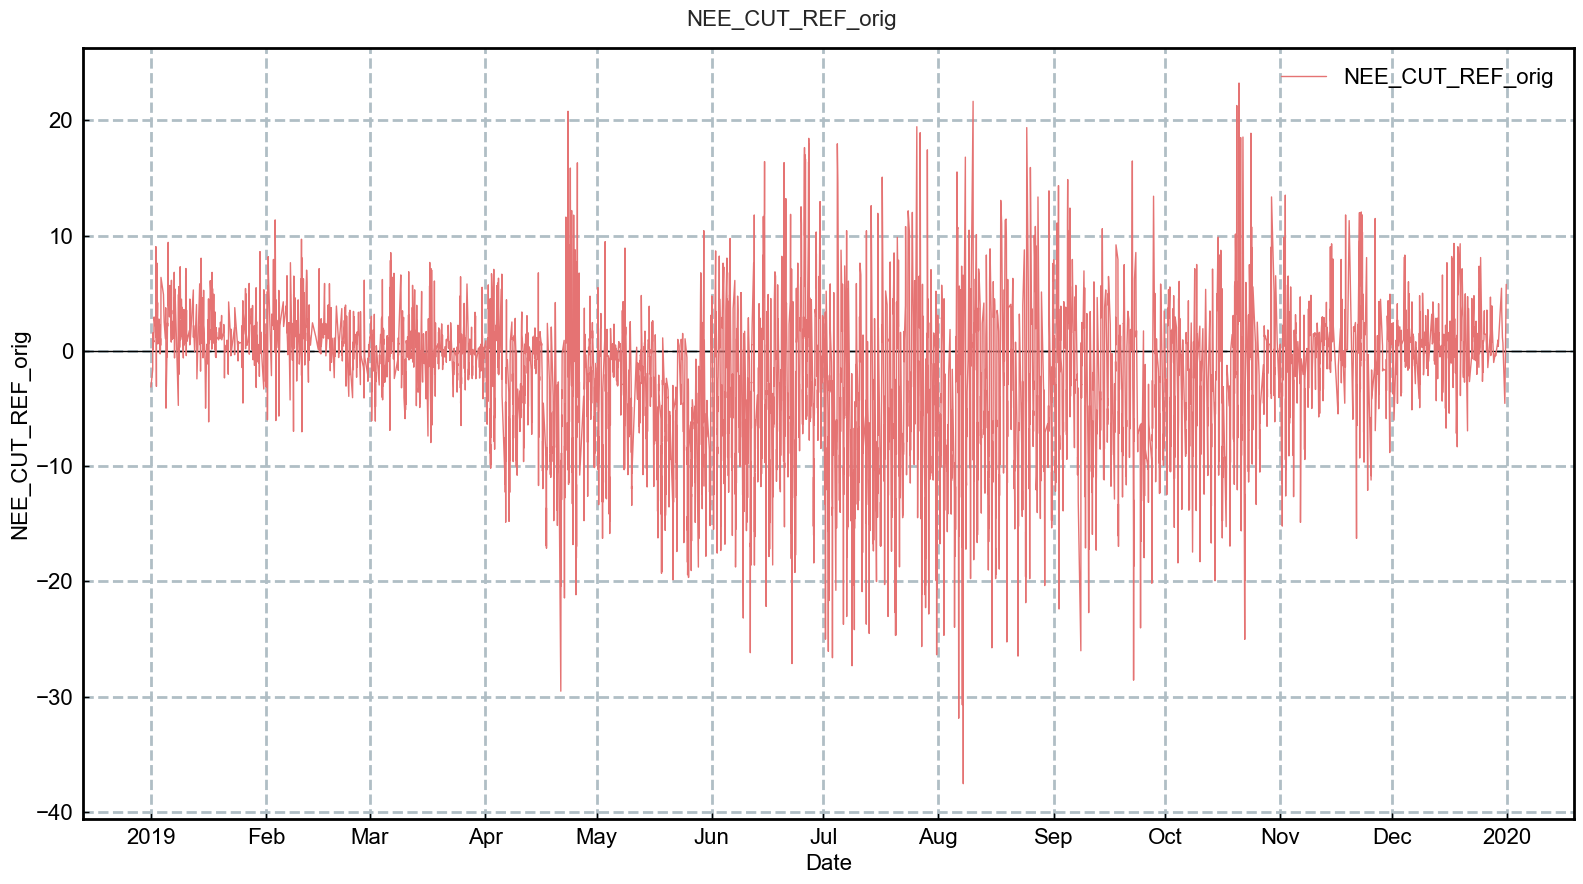

In [9]:
# TimeSeries(series=subset[TARGET_COL]).plot_interactive()
TimeSeries(series=subset[TARGET_COL]).plot()

</br>

</br>

# **Parameter optimization**

## Initialize

In [10]:
# Random forest parameters
rf_params = {
    'n_estimators': list(range(5, 55, 5)),
    'criterion': ['squared_error'],
    'max_depth': [None],
    'min_samples_split': list(range(2, 12, 2)),
    'min_samples_leaf': list(range(1, 6, 1))
}

# Optimization
opt = OptimizeParamsRFTS(
    df=subset,
    target_col=TARGET_COL,
    **rf_params
)

</br>

## Optimize parameters

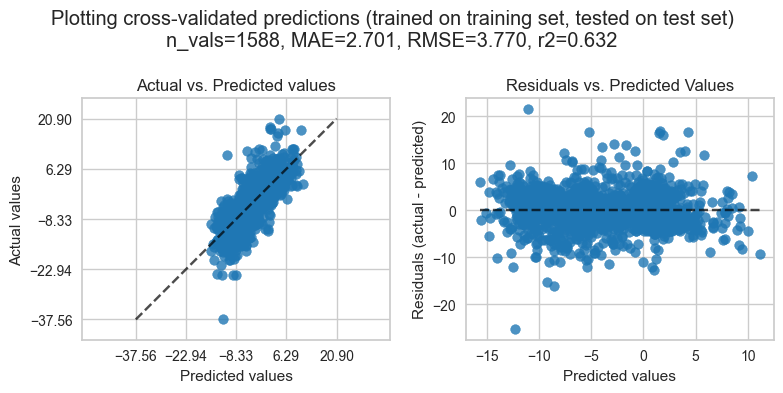

In [11]:
opt.optimize()

</br>

## Result

In [12]:
# Estimator which gave highest score (or smallest loss if specified) on the left out data
opt.best_params

{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 45}

In [13]:
# Return model scores for best model
opt.scores

{'mae': 2.700954101115681,
 'medae': 1.9620414664703698,
 'mse': 14.216448390915788,
 'rmse': 3.7704705795054,
 'mape': 2.013223227877282,
 'maxe': 25.231872836934414,
 'r2': 0.6317378100792548}

In [14]:
# Cross-validation results
opt.cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.143184,0.085452,0.001795,0.000399,squared_error,None,1,2,5,"{'criterion': 'squared_error', 'max_depth': No...",-22.269389,-22.453757,-21.100968,-18.638489,-21.029940,-18.704741,-19.202078,-19.806427,-20.628633,-17.017972,-20.085239,1.639040,250
1,0.288790,0.143986,0.002493,0.000499,squared_error,None,1,2,10,"{'criterion': 'squared_error', 'max_depth': No...",-18.333232,-19.433656,-21.058507,-17.139473,-19.803170,-17.107375,-18.911778,-18.087014,-20.227335,-14.887979,-18.498952,1.711861,240
2,0.412260,0.216243,0.002794,0.000870,squared_error,None,1,2,15,"{'criterion': 'squared_error', 'max_depth': No...",-20.087328,-19.913435,-19.433677,-17.273463,-19.386872,-16.493527,-19.201610,-16.575467,-20.286831,-15.234726,-18.388694,1.721424,236
3,0.531695,0.290560,0.003690,0.000639,squared_error,None,1,2,20,"{'criterion': 'squared_error', 'max_depth': No...",-19.855560,-19.336654,-20.148714,-16.552467,-18.567814,-16.624222,-19.553665,-17.251563,-18.534789,-14.928559,-18.135401,1.633025,227
4,0.661353,0.367278,0.004838,0.001301,squared_error,None,1,2,25,"{'criterion': 'squared_error', 'max_depth': No...",-20.155846,-19.359761,-19.669170,-17.903573,-19.363360,-15.835426,-19.858252,-16.609133,-17.912027,-13.902035,-18.056858,1.949167,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.599070,0.337741,0.005286,0.001672,squared_error,None,5,10,30,"{'criterion': 'squared_error', 'max_depth': No...",-18.415306,-18.200021,-18.327978,-15.905914,-18.279530,-15.208438,-17.909722,-15.370991,-17.041031,-14.244626,-16.890356,1.490147,61
246,0.707432,0.403892,0.005685,0.001266,squared_error,None,5,10,35,"{'criterion': 'squared_error', 'max_depth': No...",-17.622063,-18.324524,-18.539452,-15.775759,-18.001396,-15.568758,-18.142025,-15.492134,-16.227089,-14.103096,-16.779630,1.454061,25
247,0.784153,0.430470,0.005585,0.000489,squared_error,None,5,10,40,"{'criterion': 'squared_error', 'max_depth': No...",-17.989752,-18.608554,-18.057267,-16.119737,-18.378413,-15.348209,-17.721616,-15.305636,-16.363902,-14.070177,-16.796326,1.485039,33
248,0.847277,0.441351,0.005984,0.001545,squared_error,None,5,10,45,"{'criterion': 'squared_error', 'max_depth': No...",-17.887559,-18.164502,-18.200866,-15.617730,-18.080053,-15.223497,-18.036821,-14.810540,-16.261222,-13.653821,-16.593661,1.605596,1


In [15]:
# Mean cross-validated score of the best_estimator
opt.best_score

-16.593661043078004

In [16]:
# The number of cross-validation splits (folds/iterations)
opt.cv_n_splits

10

</br>

## Plot

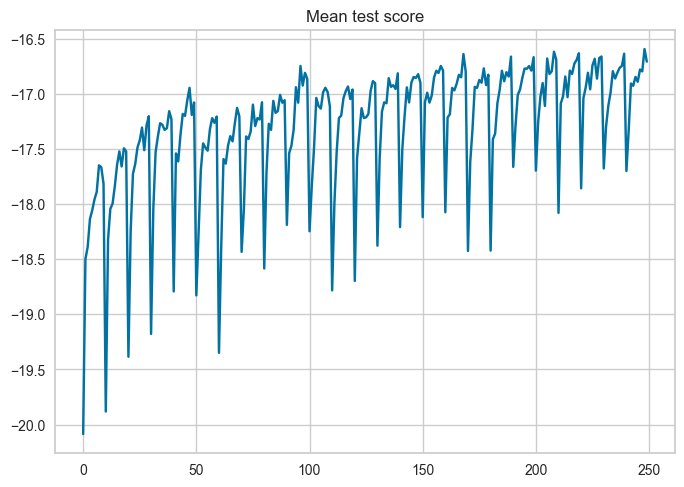

In [17]:
opt.cv_results['mean_test_score'].plot(title="Mean test score");

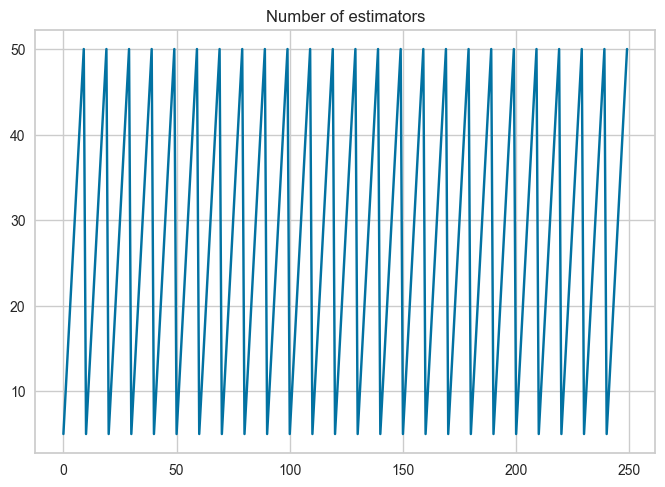

In [18]:
opt.cv_results['param_n_estimators'].plot(title="Number of estimators");

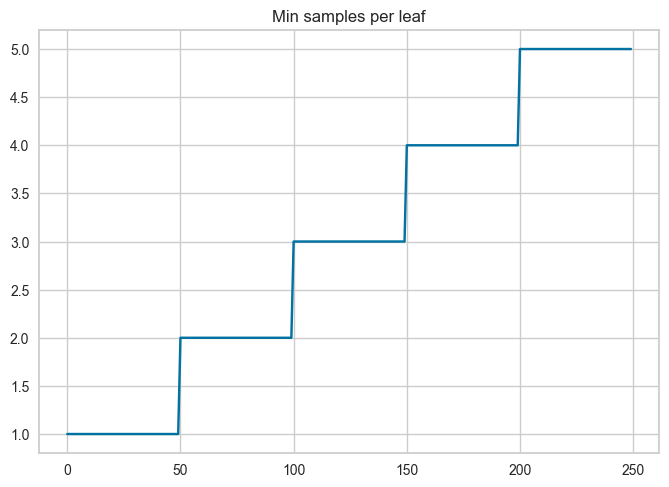

In [19]:
opt.cv_results['param_min_samples_leaf'].plot(title="Min samples per leaf");

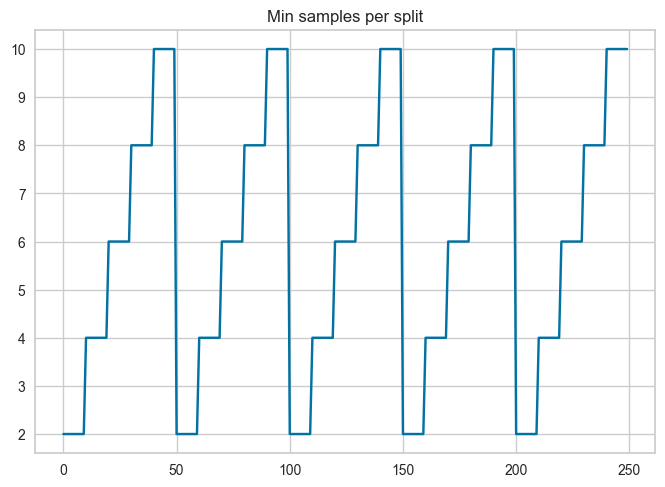

In [20]:
opt.cv_results['param_min_samples_split'].plot(title="Min samples per split");

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [21]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-10-25 14:41:09
